# Home work 3
###### 20100237

The goal of this home work is to design convolutional neural network for classification task on two dataset (a) cifar10 (b) Bricklane. As a part of this home work you will implement convolutional neural network in python and then study the effect of pooling, dropout, batch normalization and learning rate for given classifcation task. 
<br>
Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 




### Imports

In [1]:
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K
from keras.datasets import cifar10
import keras

from sklearn.model_selection import train_test_split
from IPython.display import display

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#import seaborn as sns

import os
import glob
your_id = 20100237
np.random.seed(your_id)


Using TensorFlow backend.


###### Hyperparameters

In [2]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape = (32,32,3)
images_dir = 'images/'
epochs = 25
all_histories = []

### Task 1.1   Load dataset information

[_cifar10_](https://www.cs.toronto.edu/~kriz/cifar.html) dataset contains 10 classes including airplane, bird, cat etc. You need to download dataset from [LINK](http://pjreddie.com/media/files/cifar.tgz) or [LINK2](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz). 
<br> _cifar10_ dataset is also available in keras but it is recommended to use the downloaded from above given link as ```cifar10.load_data()``` function downloads and loads complete data on RAM. 
<br> <br>
This [Github](https://github.com/EN10/CIFAR) link may be helpful to you to load _cifar10_ dataset yourself.


In [3]:
# Add your code here
# The data, split between train and test sets:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=your_id)
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')
# print(y_train[0])
# # url = http://pjreddie.com/media/files/cifar.tgz
# #

# # Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
# y_val = keras.utils.to_categorical(y_val, num_classes)

In [4]:
train_dir = './cifar/train/'
test_dir = './cifar/test/'
label_dir = './cifar/labels.txt'
train_data = np.array(glob.glob(train_dir + '*.png'))
test_data = np.array(glob.glob(test_dir + '*.png'))

classes = []
with open(label_dir) as f:
    classes = f.read().split()

train_data, val_data = train_test_split(train_data, random_state=1, test_size=0.2)
labels = {clas: i for i, clas in enumerate(classes)}

print(val_data.shape)
# print(labels)

(10000,)


### Task 1.2 Preprocessing

Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelrate the training process. 

###### Task 1.2.1 

For the images, pixel values vary from 0 to 255. To shift the values between (0,1) range, divide input image by 255. Now, retrain the model designed in part-A from scratch with preprocessed data. 

In [5]:
# You shall add your code here
def preprocessing_norm (images):
    images = images.astype('float')/255.0
    return images


###### Task 1.2.2


For the images, pixel values vary from 0 to 255. Compute the channel wise mean and standard daviation (std) for whole dataset. subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and varation to 1. 

In [6]:
# You shall add your code here
def preprocessing_meanShift (images):
    images = images.astype('float')
    for i in range(3):
        mean = img[:,:,i].mean()
        std = img[:,:,i].std()
        img[:,:,i] = (img[:,:,i].astype('float') - mean) / std
    return images


### Task 1.3  Batch Generator

For the training, we load complete data (inputs, outputs) into RAM and then provide it to "model.fit" function. However, in real when dataset is very large in size we can not load complete data on RAM. In that case, we need load data batchwise. To do this, we need to write a generator function that shall load a batch of data (images and output), preprocess images and return a tuple as (inputs, outputs) on every step. 
<br>
- The template code for batch generator is provided. You need add you script to read image(s), labels and preprocessing of images. 
<br>
- You need to check and control values of batch_start and batch_end 
<br>
- Batch generator can be implemented in multiple ways. You can use any other template of your choice.

In [7]:
def parse_path(filename):
    i = filename.rfind('_')+1
    j = filename.rfind('.')
    return labels[filename[i:j]]
    
def get_image(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

def data_generator(images_paths, batch_size = 64, preprocessing = None):
    
    total_size = len(images_paths)
    indexes = np.arange(0, total_size, batch_size)
    if total_size % batch_size != 0:
        indexes = indexes[:-1] 
    
    while True:
        np.random.shuffle(indexes) # indexes shuffled for each epoch
        for index in indexes: # 1 iteration represents 1 batch
            batch_paths = images_paths[index:index+batch_size]

            batch_x = np.array([get_image(path) for path in batch_paths])
            batch_y = np.array([parse_path(path) for path in batch_paths])
            batch_y = keras.utils.to_categorical(batch_y, num_classes)

            if (preprocessing is None):
                pass
            elif (preprocessing == 'method1'):
                batch_x = preprocessing_norm(batch_x)
            else:
                batch_x = preprocessing_meanShift(batch_x)

            yield batch_x, batch_y
          

In [8]:
# data = data_generator(train_data)
# all_data = []
# for data_object in data:
#     all_data.append(data_object)    

# print(len(all_data))

### Task 1.4 Design CNN model

In [9]:
# Add your code here

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model_initial = Model(inputs=input_im, outputs=output_class)

#### Compile model and plot

In [10]:
model_name = 'model_initial'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model_initial.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_initial, model_name+'/'+model_name+'.png')
model_initial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_________________________________________________________________


#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [11]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [12]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

##### Task 1.5.1 
Train model without using any pre-processing scheme

In [13]:
train_gen = data_generator(train_data, batch_size = batch_size)
val_gen = data_generator(val_data, batch_size = batch_size)
test_gen = data_generator(test_data, batch_size = batch_size)

In [14]:
hist_initial = model_initial.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_data)//batch_size, 
                           validation_data=val_gen, validation_steps=len(val_data)//batch_size, 
                           callbacks=callbacks, verbose=1)

all_histories.append(hist_initial)
# save model

Epoch 1/25
625/625 [==============================] - 9s 14ms/step - loss: 2.6722 - acc: 0.2254 - val_loss: 1.8254 - val_acc: 0.3255

Epoch 00001: val_loss improved from inf to 1.82538, saving model to model_initial/model_initial-01-1.83.h5
Epoch 2/25
625/625 [==============================] - 7s 12ms/step - loss: 1.7030 - acc: 0.3751 - val_loss: 1.6441 - val_acc: 0.3985

Epoch 00002: val_loss improved from 1.82538 to 1.64408, saving model to model_initial/model_initial-02-1.64.h5
Epoch 3/25
625/625 [==============================] - 7s 11ms/step - loss: 1.5354 - acc: 0.4430 - val_loss: 1.5598 - val_acc: 0.4396

Epoch 00003: val_loss improved from 1.64408 to 1.55977, saving model to model_initial/model_initial-03-1.56.h5
Epoch 4/25
625/625 [==============================] - 7s 11ms/step - loss: 1.4243 - acc: 0.4873 - val_loss: 1.5483 - val_acc: 0.4579

Epoch 00004: val_loss improved from 1.55977 to 1.54834, saving model to model_initial/model_initial-04-1.55.h5
Epoch 5/25
625/625 [====

##### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [15]:

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model_preprocessed = Model(inputs=input_im, outputs=output_class)


In [16]:
model_name = 'model_preprocessed'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model_preprocessed.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_preprocessed, model_name+'/'+model_name+'.png')
model_preprocessed.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_________________________________________________________________


In [17]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [18]:
train_gen = data_generator(train_data, batch_size = batch_size, preprocessing = 'method1')
val_gen = data_generator(val_data, batch_size = batch_size, preprocessing = 'method1')
test_gen = data_generator(test_data, batch_size = batch_size, preprocessing = 'method1')

In [19]:
hist_preprocessed = model_preprocessed.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_data)//batch_size, 
                           validation_data=val_gen, validation_steps=len(val_data)//batch_size, 
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_preprocessed)


Epoch 1/25
625/625 [==============================] - 7s 11ms/step - loss: 1.7555 - acc: 0.3680 - val_loss: 1.5469 - val_acc: 0.4488

Epoch 00001: val_loss improved from inf to 1.54687, saving model to model_preprocessed/model_preprocessed-01-1.55.h5
Epoch 2/25
625/625 [==============================] - 7s 11ms/step - loss: 1.4267 - acc: 0.4903 - val_loss: 1.3979 - val_acc: 0.4954

Epoch 00002: val_loss improved from 1.54687 to 1.39793, saving model to model_preprocessed/model_preprocessed-02-1.40.h5
Epoch 3/25
625/625 [==============================] - 7s 10ms/step - loss: 1.3254 - acc: 0.5279 - val_loss: 1.3200 - val_acc: 0.5362

Epoch 00003: val_loss improved from 1.39793 to 1.32001, saving model to model_preprocessed/model_preprocessed-03-1.32.h5
Epoch 4/25
625/625 [==============================] - 7s 10ms/step - loss: 1.2614 - acc: 0.5528 - val_loss: 1.2931 - val_acc: 0.5439

Epoch 00004: val_loss improved from 1.32001 to 1.29311, saving model to model_preprocessed/model_preproce

### Task 2.1 Pooling

Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using __fit_generator__ function. 

In [20]:
model_name = 'pool_model'

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
maxPool1 = MaxPooling2D((2,2))(conv1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(maxPool1)
maxPool2 = MaxPooling2D((2,2))(conv2)
flat = Flatten()(maxPool2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model_pooled = Model(inputs=input_im, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_pooled, model_name+'/'+model_name+'.png')
model_pooled.summary()

# save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 44)                748       
__________

In [21]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [22]:
train_gen = data_generator(train_data, batch_size = batch_size, preprocessing = 'method1')
val_gen = data_generator(val_data, batch_size = batch_size, preprocessing = 'method1')
test_gen = data_generator(test_data, batch_size = batch_size, preprocessing = 'method1')

In [23]:
hist_pooled = model_pooled.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_data)//batch_size, 
                           validation_data=val_gen, validation_steps=len(val_data)//batch_size, 
                           callbacks=callbacks, verbose=1)

all_histories.append(hist_pooled)


Epoch 1/25
625/625 [==============================] - 7s 11ms/step - loss: 2.1114 - acc: 0.2045 - val_loss: 1.9898 - val_acc: 0.2493

Epoch 00001: val_loss improved from inf to 1.98982, saving model to pool_model/pool_model-01-1.99.h5
Epoch 2/25
625/625 [==============================] - 6s 10ms/step - loss: 1.9269 - acc: 0.2768 - val_loss: 1.8687 - val_acc: 0.3025

Epoch 00002: val_loss improved from 1.98982 to 1.86868, saving model to pool_model/pool_model-02-1.87.h5
Epoch 3/25
625/625 [==============================] - 6s 10ms/step - loss: 1.8228 - acc: 0.3173 - val_loss: 1.7962 - val_acc: 0.3328

Epoch 00003: val_loss improved from 1.86868 to 1.79623, saving model to pool_model/pool_model-03-1.80.h5
Epoch 4/25
625/625 [==============================] - 6s 10ms/step - loss: 1.7636 - acc: 0.3411 - val_loss: 1.7477 - val_acc: 0.3529

Epoch 00004: val_loss improved from 1.79623 to 1.74765, saving model to pool_model/pool_model-04-1.75.h5
Epoch 5/25
625/625 [============================

### Task 3.1 Dropout


Modify the network by introducing dropout layer and train the model using __fit_generator__ function. 

In [24]:
model_name = 'dropout_model'

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
maxPool1 = MaxPooling2D((2,2))(conv1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(maxPool1)
maxPool2 = MaxPooling2D((2,2))(conv2)
flat = Flatten()(maxPool2)
dense1 = Dense(44, activation='relu')(flat)
dropOut = Dropout(rate=0.5)(dense1)
output_class = Dense(num_classes, activation='softmax')(dropOut)

model_dropout = Model(inputs=input_im, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model_dropout.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_dropout, model_name+'/'+model_name+'.png')
model_dropout.summary()

# save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 44)                748       
__________

In [25]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [26]:
train_gen = data_generator(train_data, batch_size = batch_size, preprocessing = 'method1')
val_gen = data_generator(val_data, batch_size = batch_size, preprocessing = 'method1')
test_gen = data_generator(test_data, batch_size = batch_size, preprocessing = 'method1')

In [27]:
hist_dropout = model_dropout.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_data)//batch_size, 
                           validation_data=val_gen, validation_steps=len(val_data)//batch_size, 
                           callbacks=callbacks, verbose=1)

all_histories.append(hist_dropout)


Epoch 1/25
625/625 [==============================] - 9s 14ms/step - loss: 2.1607 - acc: 0.1833 - val_loss: 2.0340 - val_acc: 0.2411

Epoch 00001: val_loss improved from inf to 2.03395, saving model to dropout_model/dropout_model-01-2.03.h5
Epoch 2/25
625/625 [==============================] - 9s 14ms/step - loss: 2.0134 - acc: 0.2396 - val_loss: 1.9323 - val_acc: 0.2791

Epoch 00002: val_loss improved from 2.03395 to 1.93227, saving model to dropout_model/dropout_model-02-1.93.h5
Epoch 3/25
625/625 [==============================] - 7s 12ms/step - loss: 1.9481 - acc: 0.2614 - val_loss: 1.8881 - val_acc: 0.2938

Epoch 00003: val_loss improved from 1.93227 to 1.88806, saving model to dropout_model/dropout_model-03-1.89.h5
Epoch 4/25
625/625 [==============================] - 9s 14ms/step - loss: 1.9128 - acc: 0.2822 - val_loss: 1.8598 - val_acc: 0.3092

Epoch 00004: val_loss improved from 1.88806 to 1.85976, saving model to dropout_model/dropout_model-04-1.86.h5
Epoch 5/25
625/625 [====

### Task 4.1 Batch Normalization

Modify the network by introducing batch normalization layer and train the model. 

In [28]:
# Add your code to complete this cell

model_name = 'model_batch_normalized'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')

conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
maxPool1 = MaxPooling2D((1,1))(conv2)
normed1 = BatchNormalization()(maxPool1)

conv3 = Conv2D(32, (3, 3), activation='relu')(normed1)
maxPool2 = MaxPooling2D((2,2))(conv3)
flat = Flatten()(maxPool2)
dense = Dense(64, activation='relu')(flat)
normed2 = BatchNormalization()(dense)

output_class = Dense(num_classes, activation='softmax')(normed2)

model_normalized = Model(inputs=input_im, outputs=output_class)
# ====================================================

adam = Adam(lr=0.001)
model_normalized.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
plot_model(model_normalized, model_name+'/'+model_name+'.png')
model_normalized.summary()


# save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 5, 32)          4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 32)          0         
__________

In [29]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [30]:
train_gen = data_generator(train_data, batch_size = batch_size, preprocessing = 'method1')
val_gen = data_generator(val_data, batch_size = batch_size, preprocessing = 'method1')
test_gen = data_generator(test_data, batch_size = batch_size, preprocessing = 'method1')

In [31]:
hist_normalized = model_normalized.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_data)//batch_size, 
                           validation_data=val_gen, validation_steps=len(val_data)//batch_size, 
                           callbacks=callbacks, verbose=1)

all_histories.append(hist_normalized)


Epoch 1/25
625/625 [==============================] - 13s 21ms/step - loss: 1.7183 - acc: 0.3804 - val_loss: 1.5866 - val_acc: 0.4382

Epoch 00001: val_loss improved from inf to 1.58665, saving model to model_batch_normalized/model_batch_normalized-01-1.59.h5
Epoch 2/25
625/625 [==============================] - 12s 19ms/step - loss: 1.4361 - acc: 0.4851 - val_loss: 1.4158 - val_acc: 0.4937

Epoch 00002: val_loss improved from 1.58665 to 1.41575, saving model to model_batch_normalized/model_batch_normalized-02-1.42.h5
Epoch 3/25
625/625 [==============================] - 12s 20ms/step - loss: 1.3280 - acc: 0.5282 - val_loss: 1.7101 - val_acc: 0.4246

Epoch 00003: val_loss did not improve from 1.41575
Epoch 4/25
625/625 [==============================] - 12s 20ms/step - loss: 1.2597 - acc: 0.5501 - val_loss: 1.3007 - val_acc: 0.5412

Epoch 00004: val_loss improved from 1.41575 to 1.30069, saving model to model_batch_normalized/model_batch_normalized-04-1.30.h5
Epoch 5/25
625/625 [======

### Task 5.1 Comparision of all model



In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why.   

In [32]:
# plot Accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()


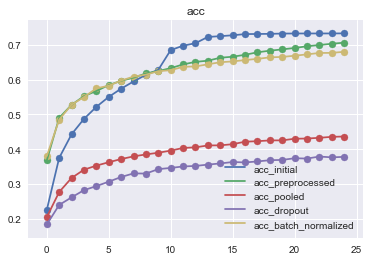

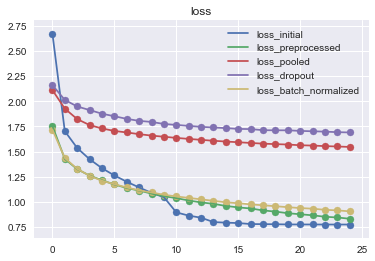

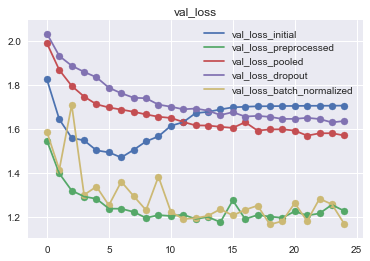

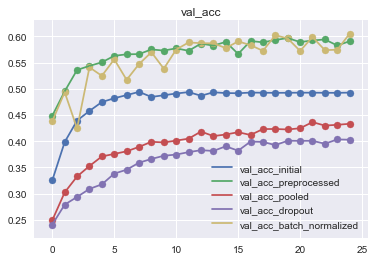

In [33]:
names = ['initial', 'preprocessed', 'pooled','dropout','batch_normalized']
plotHistory(all_histories, names, 'acc')
plotHistory(all_histories, names, 'loss')
plotHistory(all_histories, names, 'val_loss')
plotHistory(all_histories, names, 'val_acc')
# plotLosses(all_histories, names)

#### Tensorboard 


You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

- Tensorboard plot of accuracies:
!['loss'](loss.png)

- Tensorboard plot of accuracies:
!['Accuracy](acc.png)


Tensorboard plots - stepwise

!['Tensorboard'](tensorboard.png)


Tensorboard plots - relative

!['Tensorboard'](tensorboard_relative.png)


###### ADD Your Comments here

The first thing to notice is that as my batch normalization plot is way larger and more complex than the rest, it takes much more time per epoch (almost 3 times as much time per epoch) as compared to the other models. 

As far as simple loss and accuracy are concerned, the initial model which is the least complex is working the best, however, if the val_loss and the val_acc is also looked at, in that case the preprocessed version and the batch_normalized versions are working better than the initial model. This goes to show that since the initial model is the least complex, it is able to converge much more quickly, but as a result of that it is overfitting the training set. Because of this the preprocessed model is chosen by me as the best, since it minimized the losses, maximises the accuracies, and does it more quickly than batch_normalization

Why the model using Dropout and Pooling is not good is unclear to me completely. When Pooling is added as a layer to batch_normalization it performs good, but on its own Pooling makes the model worse. Similarly adding dropout to pooling makes it worse. To better investigate this it would be a good idea to also store the weights and biases in a format that tensorboard can read (I wasn't sure if we were supposed to do this in this assignment but I know it is possible in tensorboard) so that we can visualize the distributions of the weights and biases so that we know if they either become too small, or they have too high of a variance. From what we know about Pooling, since I am using MaxPooling it's possible that the inputs of that layer eventually become too large, which causes the absolute error to be too large. Adding dropout does nothing to change this, but adding batch_normalization normalizes these values into a more usable range.

### Task 5.2 Visualize Activations

In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model. For help, please refer to __Tutorials__

array([3])

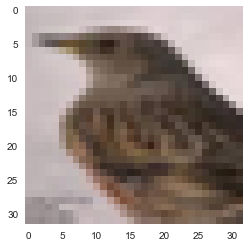

In [34]:
test_image = get_image('./cifar/train/18_bird.png')
plt.imshow(test_image);
plt.gca().grid(False);

test_reshaped = test_image.reshape((1,32,32,3))
model_initial.predict(test_reshaped).argmax(axis=1)
# 3 is the index for a cat

In [35]:
model_conv1 = Model(inputs=model_initial.get_layer('input_im').output, 
                  outputs=model_initial.get_layer('conv2d_1').output)

In [36]:
con1_activations = model_conv1.predict(test_reshaped)
con1_activations.shape

(1, 15, 15, 8)

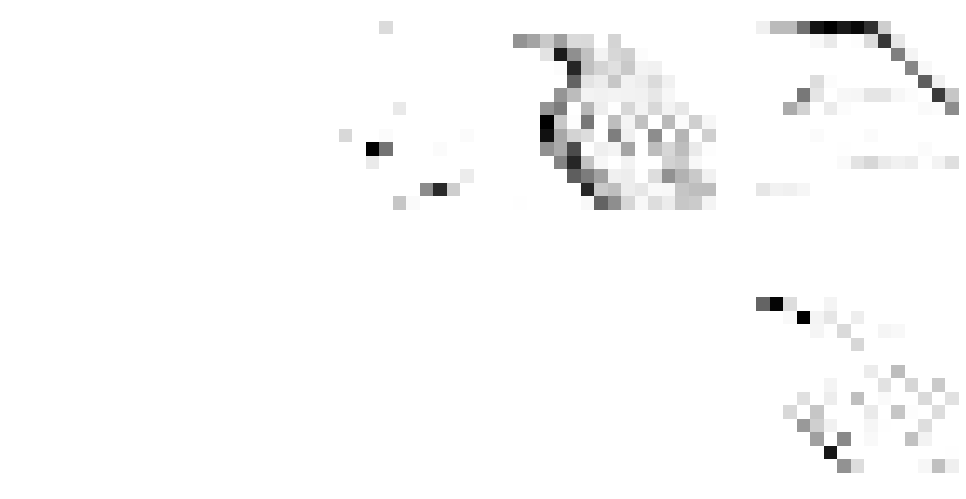

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,8), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(con1_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [38]:
model_conv2 = Model(inputs=model_initial.get_layer('input_im').output, 
                  outputs=model_initial.get_layer('conv2d_2').output)

In [39]:
con2_activations = model_conv2.predict(test_reshaped)
con2_activations.shape

(1, 7, 7, 16)

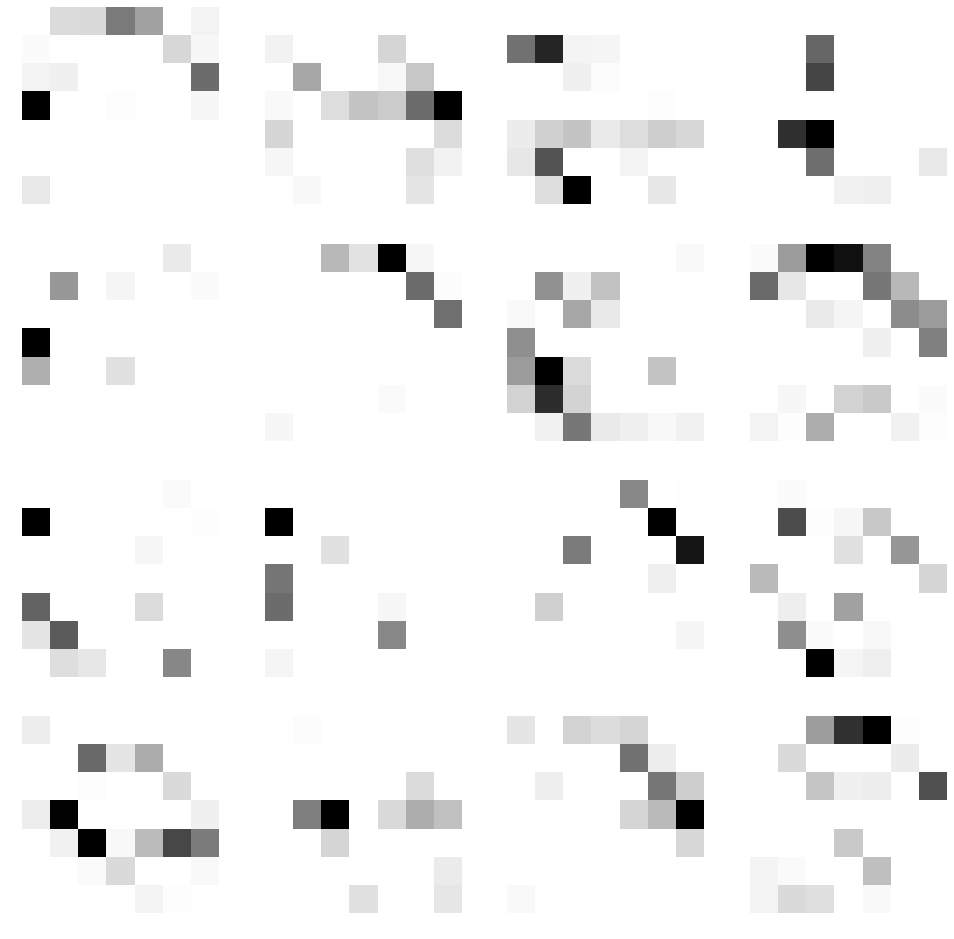

In [40]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(con2_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

### Task 6.1  Effect of learning rate

Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [41]:
def runBest(learning_rates):
    histories = []
    for lr in learning_rates:
        input_im = Input(shape=(input_shape), name='input_im')
        conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
        conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
        flat = Flatten()(conv2)
        dense1 = Dense(44, activation='relu')(flat)
        output_class = Dense(num_classes, activation='softmax')(dense1)

        model_preprocessed = Model(inputs=input_im, outputs=output_class)

        model_name = 'model_preprocessed_' + str(lr)

        if not os.path.exists('./'+model_name):
            os.mkdir(model_name)

        adam = Adam(lr=lr)
        model_preprocessed.compile(loss='categorical_crossentropy', 
                      optimizer=adam, 
                      metrics=['accuracy'])

        plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

        checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                                     monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
        cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
        tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                                    batch_size=batch_size, write_images=True)

        callbacks = [checkpoint, tensorboard, cvslogger]
        
        train_gen = data_generator(train_data, batch_size = batch_size, preprocessing = 'method1')
        val_gen = data_generator(val_data, batch_size = batch_size, preprocessing = 'method1')
        test_gen = data_generator(test_data, batch_size = batch_size, preprocessing = 'method1')

        hist_preprocessed = model_preprocessed.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_data)//batch_size, 
                                   validation_data=val_gen, validation_steps=len(val_data)//batch_size, 
                                   callbacks=callbacks, verbose=1)
        histories.append(hist_preprocessed)
        
    return histories
        

In [42]:
learning_rates = [2.5, 0.4, 0.01, 0.001, 0.00001]
lr_histories = runBest(learning_rates)

Epoch 1/25
625/625 [==============================] - 8s 12ms/step - loss: 14.3943 - acc: 0.1057 - val_loss: 14.3310 - val_acc: 0.1109

Epoch 00001: val_loss improved from inf to 14.33096, saving model to model_preprocessed_2.5/model_preprocessed_2.5-01-14.33.h5
Epoch 2/25
625/625 [==============================] - 8s 12ms/step - loss: 14.4104 - acc: 0.1060 - val_loss: 14.3310 - val_acc: 0.1109

Epoch 00002: val_loss did not improve from 14.33096
Epoch 3/25
625/625 [==============================] - 8s 12ms/step - loss: 14.4104 - acc: 0.1060 - val_loss: 14.3310 - val_acc: 0.1109

Epoch 00003: val_loss did not improve from 14.33096
Epoch 4/25
625/625 [==============================] - 8s 12ms/step - loss: 14.4104 - acc: 0.1060 - val_loss: 14.3310 - val_acc: 0.1109

Epoch 00004: val_loss did not improve from 14.33096
Epoch 5/25
625/625 [==============================] - 8s 12ms/step - loss: 14.4104 - acc: 0.1060 - val_loss: 14.3310 - val_acc: 0.1109

Epoch 00005: val_loss did not improve


Epoch 00018: val_loss did not improve from 14.47949
Epoch 19/25
625/625 [==============================] - 9s 15ms/step - loss: 14.5123 - acc: 0.0996 - val_loss: 14.4795 - val_acc: 0.1017

Epoch 00019: val_loss did not improve from 14.47949
Epoch 20/25
625/625 [==============================] - 9s 14ms/step - loss: 14.5123 - acc: 0.0996 - val_loss: 14.4795 - val_acc: 0.1017

Epoch 00020: val_loss did not improve from 14.47949
Epoch 21/25
625/625 [==============================] - 9s 15ms/step - loss: 14.5123 - acc: 0.0996 - val_loss: 14.4795 - val_acc: 0.1017

Epoch 00021: val_loss did not improve from 14.47949
Epoch 22/25
625/625 [==============================] - 11s 17ms/step - loss: 14.5123 - acc: 0.0996 - val_loss: 14.4795 - val_acc: 0.1017

Epoch 00022: val_loss did not improve from 14.47949
Epoch 23/25
625/625 [==============================] - 11s 17ms/step - loss: 14.5123 - acc: 0.0996 - val_loss: 14.4795 - val_acc: 0.1017

Epoch 00023: val_loss did not improve from 14.47949


625/625 [==============================] - 7s 12ms/step - loss: 1.2548 - acc: 0.5574 - val_loss: 1.3023 - val_acc: 0.5380

Epoch 00005: val_loss improved from 1.32465 to 1.30232, saving model to model_preprocessed_0.001/model_preprocessed_0.001-05-1.30.h5
Epoch 6/25
625/625 [==============================] - 7s 11ms/step - loss: 1.2188 - acc: 0.5682 - val_loss: 1.2765 - val_acc: 0.5502

Epoch 00006: val_loss improved from 1.30232 to 1.27647, saving model to model_preprocessed_0.001/model_preprocessed_0.001-06-1.28.h5
Epoch 7/25
625/625 [==============================] - 8s 12ms/step - loss: 1.1851 - acc: 0.5816 - val_loss: 1.2345 - val_acc: 0.5662

Epoch 00007: val_loss improved from 1.27647 to 1.23454, saving model to model_preprocessed_0.001/model_preprocessed_0.001-07-1.23.h5
Epoch 8/25
625/625 [==============================] - 10s 16ms/step - loss: 1.1582 - acc: 0.5890 - val_loss: 1.2343 - val_acc: 0.5635

Epoch 00008: val_loss improved from 1.23454 to 1.23427, saving model to mod

625/625 [==============================] - 8s 13ms/step - loss: 1.8892 - acc: 0.3377 - val_loss: 1.8896 - val_acc: 0.3369

Epoch 00014: val_loss improved from 1.90018 to 1.88961, saving model to model_preprocessed_1e-05/model_preprocessed_1e-05-14-1.89.h5
Epoch 15/25
625/625 [==============================] - 8s 13ms/step - loss: 1.8790 - acc: 0.3416 - val_loss: 1.8806 - val_acc: 0.3417

Epoch 00015: val_loss improved from 1.88961 to 1.88060, saving model to model_preprocessed_1e-05/model_preprocessed_1e-05-15-1.88.h5
Epoch 16/25
625/625 [==============================] - 8s 13ms/step - loss: 1.8691 - acc: 0.3457 - val_loss: 1.8713 - val_acc: 0.3454

Epoch 00016: val_loss improved from 1.88060 to 1.87126, saving model to model_preprocessed_1e-05/model_preprocessed_1e-05-16-1.87.h5
Epoch 17/25
625/625 [==============================] - 8s 13ms/step - loss: 1.8590 - acc: 0.3492 - val_loss: 1.8616 - val_acc: 0.3495

Epoch 00017: val_loss improved from 1.87126 to 1.86158, saving model to m

### Task 6.2 Plot loss and accuracy


Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

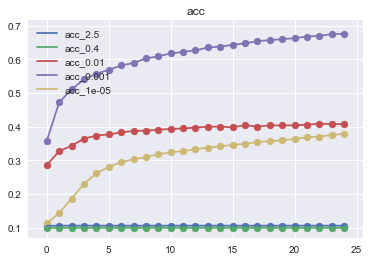

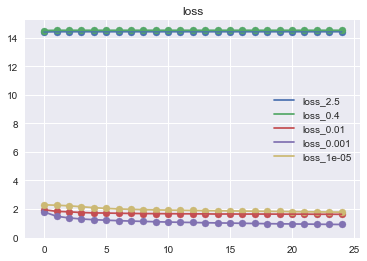

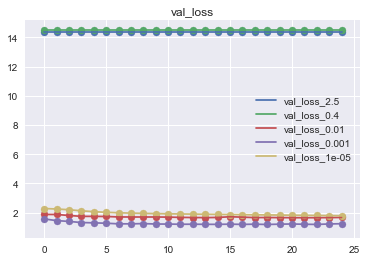

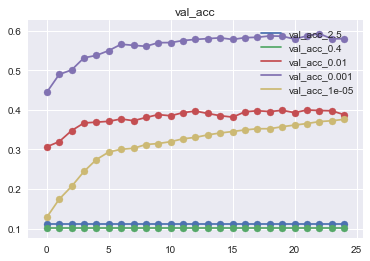

In [45]:
names = [str(lr) for lr in learning_rates]
plotHistory(lr_histories, names, 'acc')
plotHistory(lr_histories, names, 'loss')
plotHistory(lr_histories, names, 'val_loss')
plotHistory(lr_histories, names, 'val_acc')

The best learning rate is 0.001. This is because, as can be seen from the graphs, when the learning rate is too high, in this case above 0.4, then the network does not learn at all. This is because the weights keep hopping between different places on the error function and the loss actually gets worse rather than getting better, and the same happens with accuracy. If the learning rate is too low, however, the network does learn, but the steps it takes are too small and it does not converge fast enough. This is why the ReduceLROnPlateau function is used, so that we can quickly move towards the bottom given an initialy, slightly higher learning rate, and then take smaller steps as we reach closer to the bottom.